# Investigating effects of systematic uncertainties in NNs

Here we demonstrate the effect of systematic uncertainties on neural network training. For simplicity we will use the trivial MLP with `keras` and `tensorflow` described [here](https://www.tensorflow.org/guide/keras/overview). 

We will create a simple 1x32x1 MLP to distinguish two categories A and B, which have distributions in a single variable `x`. 

The model is that the `std` (standard) spectra of A and B are Gaussians with unit width that have means of 10 and 20, respectively. The `sys` (systematically smeared) spectra of A and B have an additional Gaussian smearing of 5, on top of the `std` unit Gaussian. 

We will investigate two NN models that are respectively trained on:

1. The `std` distribution before smearing. 
1. The `sys` distribution after smearing. 

The observed spectrum is designed to match the smeared `sys` distribution. 


In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
x0 = 10.0
x1 = 20.0
dx = 5.

### Make two trivial MLPs

Make two identical MLPs with one input layer, one hidden layer, one output layer. The first is the `std` one with unit-Gaussian smearing, the second is the `sys` one with the additional smearing.  

In [4]:
model_std = tf.keras.Sequential([
layers.Input(shape=(1,)),
layers.Dense(32, activation='relu'),
layers.Dense(1)])

model_std.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='mse',
              metrics=['mae'])

In [5]:
model_sys = tf.keras.Sequential([
layers.Input(shape=(1,)),
layers.Dense(32, activation='relu'),
layers.Dense(1)])

model_sys.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='mse',
              metrics=['mae'])

### Training data

We create two training sets. The first is drawn from the `std` distribution of unit Gaussians at different means, and the second `sys` is identical (item-by-item) to the first, but has an additional Gaussian smearing for the "simulated" distribution. 


In [6]:

labels0 = np.zeros( 10000 )
labels1 = np.ones ( 10000 )
labels = np.concatenate([labels0, labels1])

data0 = np.random.normal( loc=x0, size=10000)
data1 = np.random.normal( loc=x1, size=10000)
data_std = np.concatenate([data0,data1])
data_sys = data_std + np.random.normal(loc=0, scale=dx, size=20000)

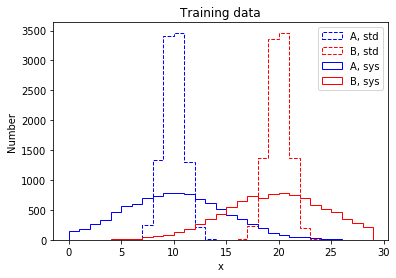

In [7]:
plt.hist(data_std[labels == 0], bins=np.arange(30),histtype = 'step', label="A, std", color='b', linestyle='dashed')
plt.hist(data_std[labels == 1], bins=np.arange(30),histtype = 'step', label="B, std", color='r', linestyle='dashed')
plt.hist(data_sys[labels == 0], bins=np.arange(30),histtype = 'step', label="A, sys", color='b')
plt.hist(data_sys[labels == 1], bins=np.arange(30),histtype = 'step', label="B, sys", color='r')
plt.title("Training data")
plt.xlabel("x")
plt.ylabel("Number")
plt.legend()
plt.show()

### Fit the model

Now we train the different models. The first is trained on the `std` distribution, and the second is trained on the `sys` smeared distribution. 

In [8]:
model_std.fit(data_std, labels, epochs=10, batch_size=32)
model_sys.fit(data_sys, labels, epochs=10, batch_size=32)

Train on 20000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 70us/sample - loss: 0.0168 - mae: 0.0945
Epoch 2/10
20000/20000 [==============================] - 1s 47us/sample - loss: 0.0094 - mae: 0.0731
Epoch 3/10
20000/20000 [==============================] - 1s 41us/sample - loss: 0.0087 - mae: 0.0681
Epoch 4/10
20000/20000 [==============================] - 1s 42us/sample - loss: 0.0082 - mae: 0.0649
Epoch 5/10
20000/20000 [==============================] - 1s 41us/sample - loss: 0.0073 - mae: 0.0621
Epoch 6/10
20000/20000 [==============================] - 1s 41us/sample - loss: 0.0062 - mae: 0.0591
Epoch 7/10
20000/20000 [==============================] - 1s 42us/sample - loss: 0.0052 - mae: 0.0549
Epoch 8/10
20000/20000 [==============================] - 1s 40us/sample - loss: 0.0043 - mae: 0.0495
Epoch 9/10
20000/20000 [==============================] - 1s 42us/sample - loss: 0.0039 - mae: 0.0474
Epoch 10/10
20000/20000 [==============================] - 

### Make an "observed" sample

The "observed" sample is the same as the `sys` smearing (two Gaussians, one of width 1 and the other of width 5, so total width of $\sqrt{26}$)

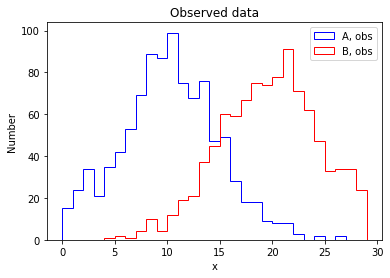

In [9]:
outdata = np.concatenate( [np.random.normal( loc=x0, size=1000),
                           np.random.normal( loc=x1, size=1000)] )
outdata += np.random.normal(loc=0, scale=dx, size=2000)
outdatalabels = np.concatenate( [np.zeros(1000), np.ones(1000)] )

plt.hist(outdata[outdatalabels == 0], bins=np.arange(30), histtype = 'step', label="A, obs", color='b')
plt.hist(outdata[outdatalabels == 1], bins=np.arange(30), histtype = 'step', label="B, obs", color='r')
plt.title("Observed data")
plt.legend()
plt.xlabel("x")
plt.ylabel("Number")
plt.show()

### Get the prediction

We will now look at the two predictions. The first will be predicted with the `std` model (no smearing in the training) and the second will be predicted with the `sys` model (trained on the smeared inputs).

In [10]:
evals_std = model_std.evaluate(x=outdata, y=outdatalabels, verbose=0)
preds_std = model_std.predict(outdata)
evals_sys = model_sys.evaluate(x=outdata, y=outdatalabels, verbose=0)
preds_sys = model_sys.predict(outdata)

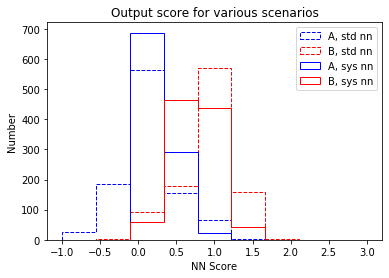

In [11]:

plt.hist(preds_std[outdatalabels == 0], bins=np.linspace(-1,3,10), histtype='step', label="A, std nn", color='b', linestyle='dashed')
plt.hist(preds_std[outdatalabels == 1], bins=np.linspace(-1,3,10), histtype='step', label="B, std nn", color='r', linestyle='dashed')
plt.hist(preds_sys[outdatalabels == 0], bins=np.linspace(-1,3,10), histtype='step', label="A, sys nn", color='b')
plt.hist(preds_sys[outdatalabels == 1], bins=np.linspace(-1,3,10), histtype='step', label="B, sys nn", color='r')
plt.legend()
plt.title("Output score for various scenarios")
plt.xlabel("NN Score")
plt.ylabel("Number")
plt.show()

### Discussion

It's very clear that the output score is completely different if we train the networks without the additional systematic smearing. As such, it is not always the case that training on a network **without** systematics, and then applying systematics to the output, is justified.

Our suggestion is to check the output score as is done here for some (ideally all) of the systematic uncertainties you're considering. To summarize:

1. Take the input MC without systematic variation. Train one network on these events ($N_1$).  
1. Apply the systematic uncertainty. Train another network on these events ($N_2$). 
1. Take separate events and apply the systematic uncertainty to them as well. Compare the network score distribution of the dataset predicted by the first and second models. 

If the distributions do not match, the systematic uncertainty should be accounted for in the training, not in the posterior. 